In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd drive/My\ Drive/3\ cource/CV/Birds\ Classification

/content/drive/My Drive/3 cource/CV/Birds Classification


In [ ]:
from tensorflow.keras.applications.efficientnet import EfficientNetB4
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.densenet import DenseNet201

from tensorflow.keras.layers import GlobalAveragePooling2D, BatchNormalization, Dense, Activation, Dropout, Flatten, AveragePooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications.xception import Xception

from sklearn.model_selection import train_test_split
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import albumentations as A
import tensorflow as tf
from tensorflow import keras

import random
import pandas as pd
import os
import numpy as np

from skimage.io import imread
from skimage.transform import resize, rotate
from tensorflow.keras.applications.efficientnet import preprocess_input

In [ ]:
IMAGESIZE = 380
def ReadAndPrepareImages(image_dir, gt_dir):
    df = pd.read_csv(gt_dir)
    X = np.zeros((df.shape[0], IMAGESIZE, IMAGESIZE, 3), dtype=np.uint8)
    y = np.zeros((df.shape[0], 50), dtype=np.uint8)
    for ind, file in tqdm(enumerate(df['filename']), desc='Reading images'):
        img = imread(os.path.join(image_dir, file))
        img = resize(img, (IMAGESIZE, IMAGESIZE, 3))
        X[ind] =  np.clip(img * 255, 0, 255).astype(np.uint8)
        y[ind][df.iloc[ind].class_id] = 1
    return X, y

In [ ]:
def focal_loss(y_true, y_pred, gamma=1):
        y_pred = tf.keras.backend.clip(y_pred, keras.backend.epsilon(), 1 - keras.backend.epsilon())
        return -keras.backend.sum((y_true * keras.backend.pow((1 - y_pred), gamma) *
                              keras.backend.log(y_pred)), axis=1)

def BuildModel():    
    base_model = EfficientNetB4(weights='imagenet', include_top=False, input_shape=(IMAGESIZE, IMAGESIZE, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    x = Dense(1024*4, kernel_initializer='he_normal')(x)
    x = BatchNormalization(momentum=0.9)(x)
    x = Activation('relu')(x)
    x = Dropout(0.9)(x)

    x = Dense(50, kernel_initializer='he_normal')(x)
    x = BatchNormalization(momentum=0.9)(x)
    x = Activation('softmax')(x)

    last_trainable = 31
    for layer in base_model.layers[0:-last_trainable]:
        layer.trainable = False
    for layer in base_model.layers[-last_trainable:]:
        layer.trainable = True

    model = Model(inputs=base_model.input, outputs=x)
    return model    
#model = BuildModel()

In [ ]:
model = BuildModel()
opt = AdamP(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, weight_decay=1e-4)
model.compile(optimizer=opt, loss=focal_loss, metrics=['accuracy'])

115269632/115263384 [==============================] - 1s 0us/step


In [ ]:
X = np.load('X.npy')
y = np.load('y.npy')

In [ ]:
X[0].shape

(380, 380, 3)

In [ ]:
X, y = ReadAndPrepareImages('00_test_img_input/train/images/', '00_test_img_input/train/gt.csv')

Reading images: 2500it [09:32,  4.37it/s]


In [ ]:
np.save('X-456.npy', X)
np.save('y-456.npy', y)

In [ ]:
y_test = np.load('y_val-456.npy')

In [ ]:
X_val = np.load('X_val-456.npy')
y_val = np.load('y_val-456.npy')

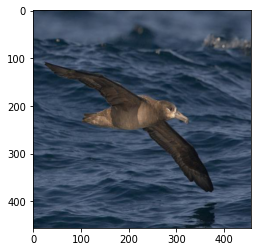

In [ ]:
plt.imshow(X_val[0])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=47)

In [ ]:
y_train.argmax(axis=-1)

array([ 4, 33, 44, ..., 47, 38, 23])

In [ ]:
transform = A.Compose([
                    A.Flip(p=0.5),
                    A.OneOf(
                        [A.RandomRotate90(p=0.8),
                        A.Transpose(p=0.8),
                        A.ShiftScaleRotate(p=0.8),
                        A.VerticalFlip()],
                        p=0.5
                    ),
                    A.OneOf(
                        [A.JpegCompression(p=0.8),
                        A.GaussNoise(p=0.8),
                        A.Blur(p=0.8)],
                        p = 0.5
                    ),
                    A.OneOf([
                        A.OpticalDistortion(p=0.8),
                        A.GridDistortion(p=0.8),
                        A.IAAPiecewiseAffine(p=0.8),],
                        p=0.5),
                    A.OneOf([
                        A.RGBShift(p=0.8),
                        A.RandomContrast(),
                        A.RandomGamma(),
                        A.RandomBrightness()
                    ], p=0.5),
                    A.RandomBrightnessContrast(p=0.5),            
                ])
def Transform(image):
    return transform(image=image)['image']

In [ ]:
def GeneratorData(X_train, y_train):
    random.seed(17)
    batch_cap = 50
    image_batch = np.zeros((batch_cap, IMAGESIZE, IMAGESIZE, 3))
    y_batch = np.zeros((batch_cap, 50))
    size_batch = 0
    while True:
        random_state = random.randint(0, 10**9)
        X, y = X_train, y_train#shuffle((np.copy(X_train), np.copy(y_train)), random_state=random_state)
        idx = np.random.permutation(len(X))
        X, y = X[idx], y[idx]
        
        for i in range(0, len(X)):
            image_batch[size_batch] = Transform(X[i])
            y_batch[size_batch] = y[i]
            size_batch += 1
            if size_batch == batch_cap:
                yield preprocess_input(image_batch.astype(np.float32)), y_batch.astype(np.float32)
                size_batch = 0

def GeneratorDataTest(X_test, y_test):
    random.seed(17)
    batch_cap = 50
    image_batch = np.zeros((batch_cap, IMAGESIZE, IMAGESIZE, 3))
    y_batch = np.zeros((batch_cap, 50))
    size_batch = 0
    while True:
        random_state = random.randint(0, 10**9)
        X, y = X_test, y_test#shuffle((np.copy(X_train), np.copy(y_train)), random_state=random_state)
        
        for i in range(0, len(X)):
            image_batch[size_batch] = X[i]
            y_batch[size_batch] = y[i]
            size_batch += 1
            if size_batch == batch_cap:
                yield  preprocess_input(image_batch.astype(np.float32)), y_batch.astype(np.float32)
                size_batch = 0

In [ ]:
"""AdamP for TensorFlow."""
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from tensorflow.python.framework import ops
from tensorflow.python.keras import backend_config
from tensorflow.python.keras.optimizer_v2 import optimizer_v2
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import control_flow_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import state_ops


class AdamP(optimizer_v2.OptimizerV2):
    _HAS_AGGREGATE_GRAD = True

    def __init__(self,
                 learning_rate=0.001,
                 beta_1=0.9,
                 beta_2=0.999,
                 epsilon=1e-8,
                 weight_decay=0.0,
                 delta=0.1, wd_ratio=0.1, nesterov=False,
                 name='AdamP',
                 **kwargs):

        super(AdamP, self).__init__(name, **kwargs)
        self._set_hyper('learning_rate', kwargs.get('lr', learning_rate))
        self._set_hyper('beta_1', beta_1)
        self._set_hyper('beta_2', beta_2)
        self._set_hyper('delta', delta)
        self._set_hyper('wd_ratio', wd_ratio)

        self.epsilon = epsilon or backend_config.epsilon()
        self.weight_decay = weight_decay
        self.nesterov = nesterov

    def _create_slots(self, var_list):
        # Create slots for the first and second moments.
        # Separate for-loops to respect the ordering of slot variables from v1.
        for var in var_list:
            self.add_slot(var, 'm')
        for var in var_list:
            self.add_slot(var, 'v')
        for var in var_list:
            self.add_slot(var, 'p')

    def _prepare_local(self, var_device, var_dtype, apply_state):
        super(AdamP, self)._prepare_local(var_device, var_dtype, apply_state)

        local_step = math_ops.cast(self.iterations + 1, var_dtype)
        beta_1_t = array_ops.identity(self._get_hyper('beta_1', var_dtype))
        beta_2_t = array_ops.identity(self._get_hyper('beta_2', var_dtype))
        beta_1_power = math_ops.pow(beta_1_t, local_step)
        beta_2_power = math_ops.pow(beta_2_t, local_step)

        lr = apply_state[(var_device, var_dtype)]['lr_t']
        bias_correction1 = 1 - beta_1_power
        bias_correction2 = 1 - beta_2_power

        delta = array_ops.identity(self._get_hyper('delta', var_dtype))
        wd_ratio = array_ops.identity(self._get_hyper('wd_ratio', var_dtype))

        apply_state[(var_device, var_dtype)].update(
            dict(
                lr=lr,
                epsilon=ops.convert_to_tensor_v2(self.epsilon, var_dtype),
                weight_decay=ops.convert_to_tensor_v2(self.weight_decay, var_dtype),
                beta_1_t=beta_1_t,
                beta_1_power=beta_1_power,
                one_minus_beta_1_t=1 - beta_1_t,
                beta_2_t=beta_2_t,
                beta_2_power=beta_2_power,
                one_minus_beta_2_t=1 - beta_2_t,
                bias_correction1=bias_correction1,
                bias_correction2=bias_correction2,
                delta=delta,
                wd_ratio=wd_ratio))

    def set_weights(self, weights):
        params = self.weights
        # If the weights are generated by Keras V1 optimizer, it includes vhats
        # optimizer has 2x + 1 variables. Filter vhats out for compatibility.
        num_vars = int((len(params) - 1) / 2)
        if len(weights) == 3 * num_vars + 1:
            weights = weights[:len(params)]
        super(AdamP, self).set_weights(weights)

    def _resource_apply_dense(self, grad, var, apply_state=None):
        var_device, var_dtype = var.device, var.dtype.base_dtype
        coefficients = ((apply_state or {}).get((var_device, var_dtype))
                        or self._fallback_apply_state(var_device, var_dtype))

        # m_t = beta1 * m + (1 - beta1) * g_t
        m = self.get_slot(var, 'm')
        m_scaled_g_values = grad * coefficients['one_minus_beta_1_t']
        m_t = state_ops.assign(m, m * coefficients['beta_1_t'] + m_scaled_g_values, use_locking=self._use_locking)

        # v_t = beta2 * v + (1 - beta2) * (g_t * g_t)
        v = self.get_slot(var, 'v')
        v_scaled_g_values = (grad * grad) * coefficients['one_minus_beta_2_t']
        v_t = state_ops.assign(v, v * coefficients['beta_2_t'] + v_scaled_g_values, use_locking=self._use_locking)

        denorm = (math_ops.sqrt(v_t) / math_ops.sqrt(coefficients['bias_correction2'])) + coefficients['epsilon']
        step_size = coefficients['lr'] / coefficients['bias_correction1']

        if self.nesterov:
            perturb = (coefficients['beta_1_t'] * m_t + coefficients['one_minus_beta_1_t'] * grad) / denorm
        else:
            perturb = m_t / denorm

        # Projection
        wd_ratio = 1
        if len(var.shape) > 1:
            perturb, wd_ratio = self._projection(var, grad, perturb, coefficients['delta'], coefficients['wd_ratio'], coefficients['epsilon'])

        # Weight decay

        if self.weight_decay > 0:
            var = state_ops.assign(var, var * (1 - coefficients['lr'] * coefficients['weight_decay'] * wd_ratio), use_locking=self._use_locking)

        var_update = state_ops.assign_sub(var, step_size * perturb, use_locking=self._use_locking)

        return control_flow_ops.group(*[var_update, m_t, v_t])


    def _resource_apply_sparse(self, grad, var, indices, apply_state=None):

        var_device, var_dtype = var.device, var.dtype.base_dtype
        coefficients = ((apply_state or {}).get((var_device, var_dtype))
                        or self._fallback_apply_state(var_device, var_dtype))
        """
        Adam
        """
        # m_t = beta1 * m + (1 - beta1) * g_t
        m = self.get_slot(var, 'm')
        m_scaled_g_values = grad * coefficients['one_minus_beta_1_t']
        m_t = state_ops.assign(m, m * coefficients['beta_1_t'],
                               use_locking=self._use_locking)
        with ops.control_dependencies([m_t]):
            m_t = self._resource_scatter_add(m, indices, m_scaled_g_values)

        # v_t = beta2 * v + (1 - beta2) * (g_t * g_t)
        v = self.get_slot(var, 'v')
        v_scaled_g_values = (grad * grad) * coefficients['one_minus_beta_2_t']
        v_t = state_ops.assign(v, v * coefficients['beta_2_t'],
                               use_locking=self._use_locking)
        with ops.control_dependencies([v_t]):
            v_t = self._resource_scatter_add(v, indices, v_scaled_g_values)

        denorm = (math_ops.sqrt(v_t) / math_ops.sqrt(coefficients['bias_correction2'])) + coefficients['epsilon']
        step_size = coefficients['lr'] / coefficients['bias_correction1']

        if self.nesterov:
            p_scaled_g_values = grad * coefficients['one_minus_beta_1_t']
            perturb = m_t * coefficients['beta_1_t']
            perturb = self._resource_scatter_add(perturb, indices, p_scaled_g_values) / denorm

        else:
            perturb = m_t / denorm

        # Projection
        wd_ratio = 1
        if len(var.shape) > 1:
            perturb, wd_ratio = self._projection(var, grad, perturb, coefficients['delta'], coefficients['wd_ratio'], coefficients['epsilon'])

        # Weight decay
        if self.weight_decay > 0:
            var = state_ops.assign(var, var * (1 - coefficients['lr'] * coefficients['weight_decay'] * wd_ratio), use_locking=self._use_locking)

        var_update = state_ops.assign_sub(var, step_size * perturb, use_locking=self._use_locking)

        return control_flow_ops.group(*[var_update, m_t, v_t])

    def _channel_view(self, x):
        return array_ops.reshape(x, shape=[x.shape[0], -1])

    def _layer_view(self, x):
        return array_ops.reshape(x, shape=[1, -1])

    def _cosine_similarity(self, x, y, eps, view_func):
        x = view_func(x)
        y = view_func(y)

        x_norm = math_ops.euclidean_norm(x, axis=-1) + eps
        y_norm = math_ops.euclidean_norm(y, axis=-1) + eps
        dot = math_ops.reduce_sum(x * y, axis=-1)

        return math_ops.abs(dot) / x_norm / y_norm

    def _projection(self, var, grad, perturb, delta, wd_ratio, eps):
        # channel_view
        cosine_sim = self._cosine_similarity(grad, var, eps, self._channel_view)
        cosine_max = math_ops.reduce_max(cosine_sim)
        compare_val = delta / math_ops.sqrt(math_ops.cast(self._channel_view(var).shape[-1], dtype=delta.dtype))

        perturb, wd = control_flow_ops.cond(pred=cosine_max < compare_val,
                                            true_fn=lambda : self.channel_true_fn(var, perturb, wd_ratio, eps),
                                            false_fn=lambda : self.channel_false_fn(var, grad, perturb, delta, wd_ratio, eps))

        return perturb, wd

    def channel_true_fn(self, var, perturb, wd_ratio, eps):
        expand_size = [-1] + [1] * (len(var.shape) - 1)
        var_n = var / (array_ops.reshape(math_ops.euclidean_norm(self._channel_view(var), axis=-1), shape=expand_size) + eps)
        perturb -= var_n * array_ops.reshape(math_ops.reduce_sum(self._channel_view(var_n * perturb), axis=-1), shape=expand_size)
        wd = wd_ratio

        return perturb, wd

    def channel_false_fn(self, var, grad, perturb, delta, wd_ratio, eps):
        cosine_sim = self._cosine_similarity(grad, var, eps, self._layer_view)
        cosine_max = math_ops.reduce_max(cosine_sim)
        compare_val = delta / math_ops.sqrt(math_ops.cast(self._layer_view(var).shape[-1], dtype=delta.dtype))

        perturb, wd = control_flow_ops.cond(cosine_max < compare_val,
                                              true_fn=lambda : self.layer_true_fn(var, perturb, wd_ratio, eps),
                                              false_fn=lambda : self.identity_fn(perturb))

        return perturb, wd

    def layer_true_fn(self, var, perturb, wd_ratio, eps):
        expand_size = [-1] + [1] * (len(var.shape) - 1)
        var_n = var / (array_ops.reshape(math_ops.euclidean_norm(self._layer_view(var), axis=-1), shape=expand_size) + eps)
        perturb -= var_n * array_ops.reshape(math_ops.reduce_sum(self._layer_view(var_n * perturb), axis=-1), shape=expand_size)
        wd = wd_ratio

        return perturb, wd

    def identity_fn(self, perturb):
        wd = 1.0

        return perturb, wd

    def get_config(self):
        config = super(AdamP, self).get_config()
        config.update({
            'learning_rate': self._serialize_hyperparameter('learning_rate'),
            'beta_1': self._serialize_hyperparameter('beta_1'),
            'beta_2': self._serialize_hyperparameter('beta_2'),
            'delta': self._serialize_hyperparameter('delta'),
            'wd_ratio': self._serialize_hyperparameter('wd_ratio'),
            'epsilon': self.epsilon,
            'weight_decay': self.weight_decay,
            'nesterov': self.nesterov
        })
        return config


from tensorflow.keras.applications.efficientnet import EfficientNetB4
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.densenet import DenseNet201

from tensorflow.keras.layers import GlobalAveragePooling2D, BatchNormalization, Dense, Activation, Dropout, Flatten, AveragePooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications.xception import Xception

from sklearn.model_selection import train_test_split
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import albumentations as A
import tensorflow as tf
from tensorflow import keras

import random
import pandas as pd
import os
import numpy as np

from skimage.io import imread
from skimage.transform import resize, rotate
from tensorflow.keras.applications.efficientnet import preprocess_input


IMAGESIZE = 380
def ReadAndPrepareImages(image_dir, train_gt):
    list_dir = os.listdir(image_dir)
    X = np.zeros((len(list_dir), IMAGESIZE, IMAGESIZE, 3), dtype=np.uint8)
    y = np.zeros((len(list_dir), 50), dtype=np.uint8)
    
    for ind, file in tqdm(enumerate(list_dir), desc='Reading images'):
        img = imread(os.path.join(image_dir, file))
        img = resize(img, (IMAGESIZE, IMAGESIZE, 3))
        X[ind] =  np.clip(img * 255, 0, 255).astype(np.uint8)
        y[ind][train_gt[file]] = 1
    return X, y


def ReadTest(image_dir):
    list_dir = os.listdir(image_dir)
    X = np.zeros((len(list_dir), IMAGESIZE, IMAGESIZE, 3), dtype=np.uint8)
    for ind, file in tqdm(enumerate(list_dir), desc='Reading images'):
        img = imread(os.path.join(image_dir, file))
        img = resize(img, (IMAGESIZE, IMAGESIZE, 3))
        X[ind] =  np.clip(img * 255, 0, 255).astype(np.uint8)
    return X


def focal_loss(y_true, y_pred, gamma=1):  
    y_pred = tf.keras.backend.clip(y_pred, keras.backend.epsilon(), 1 - keras.backend.epsilon())
    return -keras.backend.sum((y_true * keras.backend.pow((1 - y_pred), gamma) *
                          keras.backend.log(y_pred)), axis=1)
    



def BuildModel():
    base_model = EfficientNetB4(weights='imagenet', include_top=False, input_shape=(IMAGESIZE, IMAGESIZE, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    x = Dense(1024*4, kernel_initializer='he_normal')(x)
    x = BatchNormalization(momentum=0.9)(x)
    x = Activation('relu')(x)
    x = Dropout(0.9)(x)

    x = Dense(50, kernel_initializer='he_normal')(x)
    x = BatchNormalization(momentum=0.9)(x)
    x = Activation('softmax')(x)

    last_trainable = 31
    for layer in base_model.layers[0:-last_trainable]:
        layer.trainable = False
    for layer in base_model.layers[-last_trainable:]:
        layer.trainable = True
   
    model = Model(inputs=base_model.input, outputs=x)
    return model    


def GeneratorData(X_train, y_train):
    random.seed(17)
    batch_cap = 4
    image_batch = np.zeros((batch_cap, IMAGESIZE, IMAGESIZE, 3))
    y_batch = np.zeros((batch_cap, 50))
    size_batch = 0
    while True:
        random_state = random.randint(0, 10**9)
        X, y = X_train, y_train#shuffle((np.copy(X_train), np.copy(y_train)), random_state=random_state)
        idx = np.random.permutation(len(X))
        X, y = X[idx], y[idx]
        
        for i in range(0, len(X)):
            image_batch[size_batch] = Transform(X[i])
            y_batch[size_batch] = y[i]
            size_batch += 1
            if size_batch == batch_cap:
                yield preprocess_input(image_batch.astype(np.float32)), y_batch.astype(np.float32)
                size_batch = 0


def GeneratorDataTest(X_test, y_test):
    random.seed(17)
    batch_cap = 50
    image_batch = np.zeros((batch_cap, IMAGESIZE, IMAGESIZE, 3))
    y_batch = np.zeros((batch_cap, 50))
    size_batch = 0
    while True:
        random_state = random.randint(0, 10**9)
        X, y = X_test, y_test#shuffle((np.copy(X_train), np.copy(y_train)), random_state=random_state)
        
        for i in range(0, len(X)):
            image_batch[size_batch] = X[i]
            y_batch[size_batch] = y[i]
            size_batch += 1
            if size_batch == batch_cap:
                yield  preprocess_input(image_batch.astype(np.float32)), y_batch.astype(np.float32)
                size_batch = 0


transform = A.Compose([
            A.Flip(p=0.5),
            A.OneOf(
                [A.RandomRotate90(p=0.8),
                A.Transpose(p=0.8),
                A.ShiftScaleRotate(p=0.8),
                A.VerticalFlip()],
                p=0.5
            ),
            A.OneOf(
                [A.JpegCompression(p=0.8),
                A.GaussNoise(p=0.8),
                A.Blur(p=0.8)],
                p = 0.5
            ),
            A.OneOf([
                A.OpticalDistortion(p=0.8),
                A.GridDistortion(p=0.8),
                A.IAAPiecewiseAffine(p=0.8),],
                p=0.5),
            A.OneOf([
                A.RGBShift(p=0.8),
                A.RandomContrast(),
                A.RandomGamma(),
                A.RandomBrightness()
            ], p=0.5),
            A.RandomBrightnessContrast(p=0.5),            
                ])
def Transform(image):
    return transform(image=image)['image']


def train_classifier(train_gt, image_dir, fast_train=True):
    # X_train, y_train = ReadAndPrepareImages(image_dir, train_gt)
    model = BuildModel()
    
    opt = AdamP(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, weight_decay=1e-4)
    model.compile(optimizer=opt, loss=focal_loss, metrics=['accuracy'])
    
    if fast_train:
        model.fit( GenerateReaderTrain(image_dir, train_gt), steps_per_epoch=1, epochs=1)
    else:
        model.fit( GenerateReaderTrain(image_dir, train_gt), steps_per_epoch=50, epochs=100)
    return model


def GenerateReaderTrain(image_dir, train_gt):
    list_dir = os.listdir(image_dir)
    batch_cap = 10
    size_batch = 0
    X = np.zeros((batch_cap, IMAGESIZE, IMAGESIZE, 3), dtype=np.uint8)
    y = np.zeros((batch_cap, 50))
    for ind, file in tqdm(enumerate(list_dir), desc='Reading images'):
        img = imread(os.path.join(image_dir, file))
        img = resize(img, (IMAGESIZE, IMAGESIZE, 3))
        X[size_batch] =  np.clip(img * 255, 0, 255).astype(np.uint8)
        y[size_batch] = train_gt[file]
        size_batch += 1
        if size_batch == batch_cap:
            yield  preprocess_input(X.astype(np.float32)), y
            size_batch = 0


def GenerateReaderTest(image_dir):
    list_dir = os.listdir(image_dir)
    batch_cap = 10
    size_batch = 0
    X = np.zeros((batch_cap, IMAGESIZE, IMAGESIZE, 3), dtype=np.uint8)
    for ind, file in tqdm(enumerate(list_dir), desc='Reading images'):
        img = imread(os.path.join(image_dir, file))
        img = resize(img, (IMAGESIZE, IMAGESIZE, 3))
        X[size_batch] =  np.clip(img * 255, 0, 255).astype(np.uint8)
        size_batch += 1
        if size_batch == batch_cap:
            yield  preprocess_input(X.astype(np.float32))
            size_batch = 0


def classify(model, test_image_dir):
    list_dir = os.listdir(test_image_dir)
    y_pred = model.predict(GenerateReaderTest(test_image_dir))
    y = np.argmax(y_pred, axis=-1)
    d = dict()
    for ind, filename in enumerate(list_dir):
        d[filename] = y[ind]
    return d





In [ ]:
model = train_classifier()

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoints = ModelCheckpoint('checkpoints380/MYmodel-effic1-{epoch:03d}-{val_accuracy:.4f}-{val_loss:.5f}.hdf5', 
                              monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=True)

In [ ]:
history = model.fit(GeneratorData(X_train, y_train), steps_per_epoch=50, epochs=200, validation_data=(preprocess_input(X_test.astype(np.float32)), y_test.astype(np.float32)), 
                    callbacks=checkpoints)


Epoch 1/200
50/50 [==============================] - ETA: 0s - loss: 2.4114 - accuracy: 0.4600
Epoch 00001: saving model to checkpoints380/MYmodel-effic1-001-0.8820-0.51566.hdf5
50/50 [==============================] - 14s 284ms/step - loss: 2.4114 - accuracy: 0.4600 - val_loss: 0.5157 - val_accuracy: 0.8820
Epoch 2/200
50/50 [==============================] - ETA: 0s - loss: 2.4623 - accuracy: 0.4350
Epoch 00002: saving model to checkpoints380/MYmodel-effic1-002-0.8740-0.53526.hdf5
50/50 [==============================] - 13s 261ms/step - loss: 2.4623 - accuracy: 0.4350 - val_loss: 0.5353 - val_accuracy: 0.8740
Epoch 3/200
50/50 [==============================] - ETA: 0s - loss: 2.4429 - accuracy: 0.4400
Epoch 00003: saving model to checkpoints380/MYmodel-effic1-003-0.8780-0.54700.hdf5
50/50 [==============================] - 12s 239ms/step - loss: 2.4429 - accuracy: 0.4400 - val_loss: 0.5470 - val_accuracy: 0.8780
Epoch 4/200
50/50 [==============================] - ETA: 0s - loss: 2

KeyboardInterrupt: ignored

In [ ]:
model.fit(GeneratorData(X, y), steps_per_epoch=50, epochs=10, validation_data=(preprocess_input(X_val), y_val),
                    callbacks=[tf.keras.callbacks.ModelCheckpoint("bestkaban-effic-fc-wf.hdf5", mode="min", monitor="val_loss",
                                                                  save_best_only=True, save_weights_only=False)])

In [ ]:
model.fit_generator(GeneratorData(X_train, y_train), steps_per_epoch=50, epochs=20000, validation_data=(X_test, y_test),
                    callbacks=[tf.keras.callbacks.ModelCheckpoint("bestkaban-wf.hdf5", mode="min", monitor="val_loss",
                                                                  save_best_only=True, save_weights_only=False)])

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize, rotate
import os
from os.path import join
from tensorflow import keras
from keras.applications.resnet50 import ResNet50
from keras.layers import Dense, GlobalAveragePooling2D, Input
from keras.models import Model
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import albumentations as A
#from tensorflow_addons.optimizers import AdamP

In [ ]:
opt = AdamP(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, weight_decay=1e-4)
model.compile(optimizer=opt, loss=focal_loss, metrics=['accuracy'])

In [ ]:
model = BuildModel()

NameError: ignored

In [ ]:
model.load_weights('checkpoints380/MYmodel-effic1-103-0.8940-0.42952.hdf5')

In [ ]:
model.save('MyBestModel.hdf5')

In [ ]:
model = load_model('MyBestModel.hdf5')

In [ ]:
from classification import classify

In [ ]:
d = model.predict(X)

In [ ]:
model = load_model('MyBestModel.hdf5')